In [7]:
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pylab as plt
import yfinance as yf
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from numba import jit, prange
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing

register_matplotlib_converters()

In [8]:
nvidia_df = pd.read_csv("../00_data/Sentiment_Only_Data_22MAR.gz", compression="gzip")

In [9]:
nvidia_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Index', 'videoID', 'datePub',
       'searchedDate', 'VideoTitle', 'channelTitle', 'viewCount', 'likeCount',
       'dislikeCount', 'captionString', 'videoTitleSentimentScore_pos',
       'videoTitleSentimentScore_neg', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'videoTitleSentimentScore_com', 'num_days_since_pub',
       'viewcounts_weighted', 'like_count_weighted', 'dislike_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted', 'Date'],
      dtype='object')

In [4]:
# This is a function to generate response variable dataframe
# Decision rule:
# If the change in "High" in 5 days is greater than 3%, we give it label "buy"
# If the change in "High" in 5 days is smaller than -3%, we give it label "sell"
# Otherwise, we give it label "hold
def create_response(start_date, end_date, stock_name):
    import pandas as pd
    import numpy as np
    import yfinance as yf

    # get stock info
    data = (
        yf.download(stock_name, start=start_date, end=end_date)
        .asfreq("D")
        .fillna(method="ffill")
    )
    # create percentage dict
    percent_dict = {}
    for i in range(len(data) - 5):
        cur_high = data.iloc[i, :]["High"]
        future_high = data.iloc[i + 5, :]["High"]
        percent_dict[data.index[i]] = (future_high - cur_high) / cur_high
    response_df = pd.DataFrame.from_dict(
        percent_dict, orient="index", columns=["percent_change"]
    )
    # Decsion rule
    bins = [-(np.inf), -0.03, 0.03, np.inf]
    names = ["sell", "hold", "buy"]
    response_df["action"] = pd.cut(response_df["percent_change"], bins, labels=names)
    response_df["close"] = data["Close"]
    response_df = response_df.reset_index()
    return response_df

In [16]:
data = (
    yf.download("NVDA", "2020-10-02", "2021-03-28", interval = "1h")
)

[*********************100%***********************]  1 of 1 completed


In [17]:
data

,Open,High,Low,Close,Adj Close,Volume
2020-10-02 09:30:00-04:00,529.000000,540.780029,526.450012,539.716492,539.716492,3628705
2020-10-02 10:30:00-04:00,539.695007,539.695007,533.000000,533.037476,533.037476,1633426
2020-10-02 11:30:00-04:00,533.020020,533.674988,525.099976,531.130676,531.130676,2433366
2020-10-02 12:30:00-04:00,531.131287,533.030518,527.140015,529.344971,529.344971,1155026
2020-10-02 13:30:00-04:00,529.250000,530.919922,526.580078,528.530701,528.530701,1149368
...,...,...,...,...,...,...
2021-03-26 11:30:00-04:00,495.869995,502.540009,495.260010,502.135010,502.135010,1002947
2021-03-26 12:30:00-04:00,502.250000,506.880005,501.804993,506.059998,506.059998,914558
2021-03-26 13:30:00-04:00,506.049988,506.343109,498.670013,500.834991,500.834991,894107
2021-03-26 14:30:00-04:00,500.779999,506.640015,497.700012,506.239990,506.239990,1155489


In [7]:
responce_df = create_response("2020-10-02", "2021-03-28", "NVDA")

[*********************100%***********************]  1 of 1 completed


### BY VIDEO DATA SET

In [8]:
X_feautures_pre_merge = nvidia_df.copy()

In [9]:
X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

In [10]:
X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_full_feautures_final = X_feautures_pre_merge.merge(
    responce_df, left_on="Date", right_on="index", how="left", indicator=True
)

In [11]:
X_full_feautures_final.tail()

,Unnamed: 0,Unnamed: 0.1,Index,videoID,datePub,searchedDate,VideoTitle,channelTitle,viewCount,likeCount,...,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,Date,index,percent_change,action,close,_merge
20788,20788,20788,20,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2021-03-19 18:03:20.670031+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3741789,148430,...,22.789189,0.972381,0.972381,19667.258436,2021-03-19,2021-03-19,0.0184,hold,513.830017,both
20789,20789,20789,21,3dJhDqLjPN0,2021-02-24 21:59:34+00:00,2021-03-19 18:03:21.320922+00:00,NVIDIA (NVDA) Stock Analysis - Q4 Earnings + I...,The Investor Channel,7773,269,...,0.043478,0.996296,0.996296,336.704831,2021-03-19,2021-03-19,0.0184,hold,513.830017,both
20790,20790,20790,22,H1DApIvOCMw,2021-02-26 17:35:37+00:00,2021-03-19 18:03:21.788746+00:00,My SALTY Review of the NVIDIA RTX 3060...,JayzTwoCents,1013948,51773,...,31.909091,0.986622,0.986622,45471.982159,2021-03-19,2021-03-19,0.0184,hold,513.830017,both
20791,20791,20791,23,Y5J2bgXiK9g,2021-03-09 17:00:10+00:00,2021-03-19 18:03:22.387116+00:00,Should Nvidia Stop Selling 3060s?,LMG Clips,53940,2238,...,3.000000,0.985469,0.985469,4832.381410,2021-03-19,2021-03-19,0.0184,hold,513.830017,both
20792,20792,20792,24,HZigkcTxRo0,2021-02-25 03:01:00+00:00,2021-03-19 18:03:22.919039+00:00,Nvidia’s plan ISN’T WORKING,TechLinked,1394144,145393,...,176.217391,0.972880,0.972880,58971.068972,2021-03-19,2021-03-19,0.0184,hold,513.830017,both


In [12]:
X_full_feautures_final

,Unnamed: 0,Unnamed: 0.1,Index,videoID,datePub,searchedDate,VideoTitle,channelTitle,viewCount,likeCount,...,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,Date,index,percent_change,action,close,_merge
0,0,0,0,y4fb_R5Ogw0,2020-10-01 05:16:02+00:00,2020-10-02 01:45:21.553469+00:00,"2x NVIDIA RTX 3090 SLI Benchmarks: 500FPS, 700...",Gamers Nexus,367472,15701,...,260.000000,0.983710,0.983710,361485.989098,2020-10-02,2020-10-02,0.044362,buy,522.489990,both
1,1,1,1,ALEXVtnNEwA,2020-09-01 17:15:57+00:00,2020-10-02 01:45:22.351801+00:00,NVIDIA GeForce Special Event Livestream,IGN,543115,16860,...,13.258065,0.976203,0.976203,17102.917066,2020-10-02,2020-10-02,0.044362,buy,522.489990,both
2,2,2,2,E98hC9e__Xs,2020-09-01 16:42:07+00:00,2020-10-02 01:45:23.252012+00:00,NVIDIA GeForce RTX 30 Series | Official Launch...,NVIDIA GeForce,1484075,54741,...,36.612903,0.979687,0.979687,46900.942857,2020-10-02,2020-10-02,0.044362,buy,522.489990,both
3,3,3,3,nMns8t4OhI0,2020-09-30 23:00:06+00:00,2020-10-02 01:45:23.922084+00:00,NVIDIA Responds to RTX 3080 Crashes...,JayzTwoCents,561238,27766,...,442.500000,0.969111,0.969111,271950.966947,2020-10-02,2020-10-02,0.044362,buy,522.489990,both
4,4,4,4,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2020-10-02 01:45:24.592244+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3391565,141852,...,247.562500,0.972835,0.972835,206214.585797,2020-10-02,2020-10-02,0.044362,buy,522.489990,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20788,20788,20788,20,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2021-03-19 18:03:20.670031+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3741789,148430,...,22.789189,0.972381,0.972381,19667.258436,2021-03-19,2021-03-19,0.018400,hold,513.830017,both
20789,20789,20789,21,3dJhDqLjPN0,2021-02-24 21:59:34+00:00,2021-03-19 18:03:21.320922+00:00,NVIDIA (NVDA) Stock Analysis - Q4 Earnings + I...,The Investor Channel,7773,269,...,0.043478,0.996296,0.996296,336.704831,2021-03-19,2021-03-19,0.018400,hold,513.830017,both
20790,20790,20790,22,H1DApIvOCMw,2021-02-26 17:35:37+00:00,2021-03-19 18:03:21.788746+00:00,My SALTY Review of the NVIDIA RTX 3060...,JayzTwoCents,1013948,51773,...,31.909091,0.986622,0.986622,45471.982159,2021-03-19,2021-03-19,0.018400,hold,513.830017,both
20791,20791,20791,23,Y5J2bgXiK9g,2021-03-09 17:00:10+00:00,2021-03-19 18:03:22.387116+00:00,Should Nvidia Stop Selling 3060s?,LMG Clips,53940,2238,...,3.000000,0.985469,0.985469,4832.381410,2021-03-19,2021-03-19,0.018400,hold,513.830017,both


### BY DAY

In [13]:
X_features = nvidia_df.filter(
    [
        "videoTitleSentimentScore_pos",
        "videoTitleSentimentScore_neg",
        "videoTitleSentimentScore_com",
        "captionSentimentScore_pos",
        "captionSentimentScore_neg",
        "captionSentimentScore_com",
        "num_days_since_pub",
        "viewcounts_weighted",
        "like_count_weighted",
        "like_dislike_ratio",
        "weighted_like_dislike_ratio",
        "like_dislike_ratio_by_viewcounts_weighted",
        "Date",
    ],
    axis=1,
)

X_feautures_pre_merge = X_features.groupby(["Date"]).mean().reset_index()

X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_agg_by_day_feautures_final = X_feautures_pre_merge.merge(
    responce_df, left_on="Date", right_on="index", how="left", indicator=True
)

columns = ['videoTitleSentimentScore_pos', 'videoTitleSentimentScore_neg',
       'videoTitleSentimentScore_com', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'num_days_since_pub', 'viewcounts_weighted', 'like_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted']

min_max_scaler = preprocessing.MinMaxScaler()
X_agg_by_day_feautures_final[columns] = min_max_scaler.fit_transform(X_agg_by_day_feautures_final[columns])
X_agg_by_day_feautures_final

In [15]:
X_agg_by_day_feautures_final.columns

Index(['Date', 'videoTitleSentimentScore_pos', 'videoTitleSentimentScore_neg',
       'videoTitleSentimentScore_com', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'num_days_since_pub', 'viewcounts_weighted', 'like_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted', 'index', 'percent_change',
       'action', 'close', '_merge'],
      dtype='object')

In [16]:
from sklearn import preprocessing

columns = ['videoTitleSentimentScore_pos', 'videoTitleSentimentScore_neg',
       'videoTitleSentimentScore_com', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'num_days_since_pub', 'viewcounts_weighted', 'like_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted']

min_max_scaler = preprocessing.MinMaxScaler()
X_agg_by_day_feautures_final[columns] = min_max_scaler.fit_transform(X_agg_by_day_feautures_final[columns])
X_agg_by_day_feautures_final

,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,videoTitleSentimentScore_com,captionSentimentScore_pos,captionSentimentScore_neg,captionSentimentScore_com,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,index,percent_change,action,close,_merge
0,2020-10-02,0.588176,0.854914,0.273646,0.673688,0.870899,0.872555,0.000000,0.993597,0.554833,0.776479,0.776479,0.987466,2020-10-02,0.044362,buy,522.489990,both
1,2020-10-03,0.328178,0.564621,0.305900,0.892319,0.815487,0.947722,0.172440,0.995078,0.597622,0.769701,0.769701,0.990701,2020-10-03,0.041791,buy,522.489990,both
2,2020-10-04,0.403093,0.509770,0.375409,0.803539,0.838507,0.904500,0.036627,0.914150,0.513864,0.899106,0.899106,0.909938,2020-10-04,0.022541,hold,522.489990,both
3,2020-10-05,0.463729,0.561100,0.367878,0.806298,0.705077,0.853266,0.018569,0.846534,0.534266,0.827998,0.827998,0.843140,2020-10-05,0.013192,hold,545.700012,both
4,2020-10-06,0.407355,0.591517,0.297611,0.798844,0.697593,0.790280,0.014701,1.000000,0.669901,0.892050,0.892050,1.000000,2020-10-06,-0.022469,hold,549.460022,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2021-03-15,0.056764,0.291052,0.394573,0.434932,0.678216,0.537516,0.896081,0.209130,0.177269,0.195401,0.195401,0.208140,2021-03-15,-0.021599,hold,527.650024,both
114,2021-03-16,0.055643,0.550908,0.266624,0.714759,0.795954,0.800546,0.888286,0.203985,0.174330,0.158083,0.158083,0.202597,2021-03-16,-0.043737,sell,531.650024,both
115,2021-03-17,0.065732,0.569127,0.308976,0.679109,0.759779,0.779278,0.909430,0.202291,0.158599,0.218095,0.218095,0.201302,2021-03-17,-0.004367,hold,533.650024,both
116,2021-03-18,0.228492,0.531111,0.398332,0.630096,0.710848,0.703516,0.876286,0.213518,0.177277,0.255117,0.255117,0.212404,2021-03-18,0.012174,hold,508.899994,both


### Plotting the fluctuations of price and video compound video title sentiment 

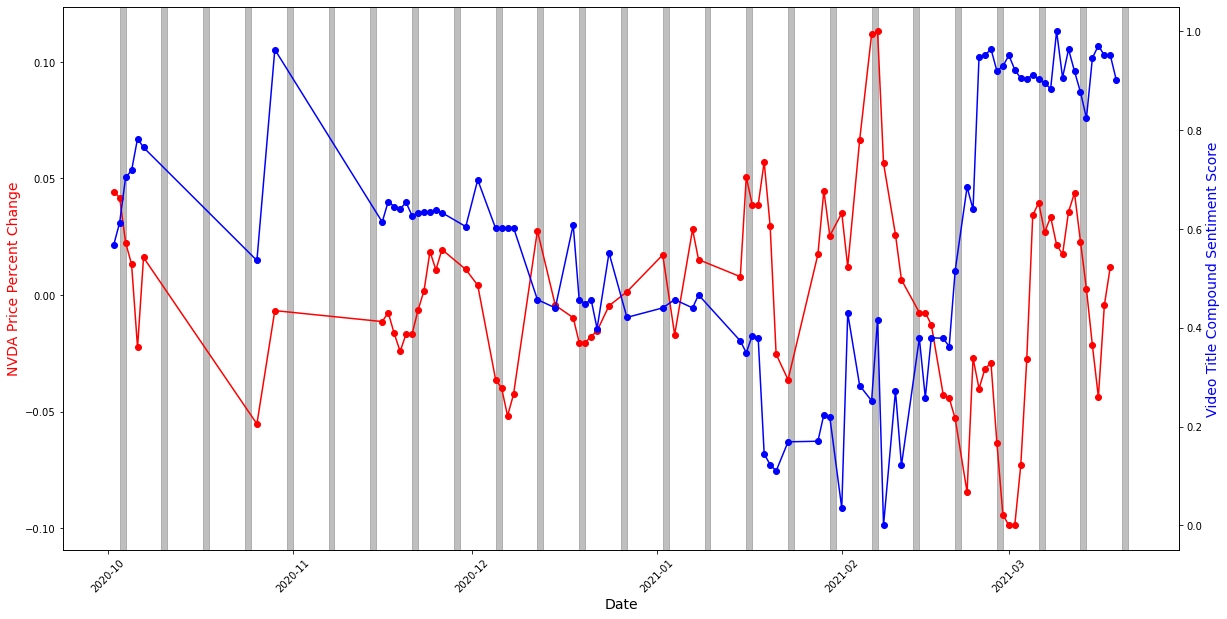

In [49]:
x = pd.DataFrame(X_agg_by_day_feautures_final.Date)
# print(full_joined_df["compound"])
y = pd.DataFrame(X_agg_by_day_feautures_final["videoTitleSentimentScore_com"])

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot



ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.percent_change, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Price Percent Change", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Title Compound Sentiment Score", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)

plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

In [18]:
X_agg_by_day_feautures_final["viewcounts_weighted"] * X_agg_by_day_feautures_final["captionSentimentScore_com"]

0      0.866968
1      0.943057
2      0.826849
3      0.722319
4      0.790280
         ...   
113    0.112411
114    0.163299
115    0.157641
116    0.150213
117    0.181419
Length: 118, dtype: float64

### Plotting the fluctuations of price and caption compound video title sentiment 

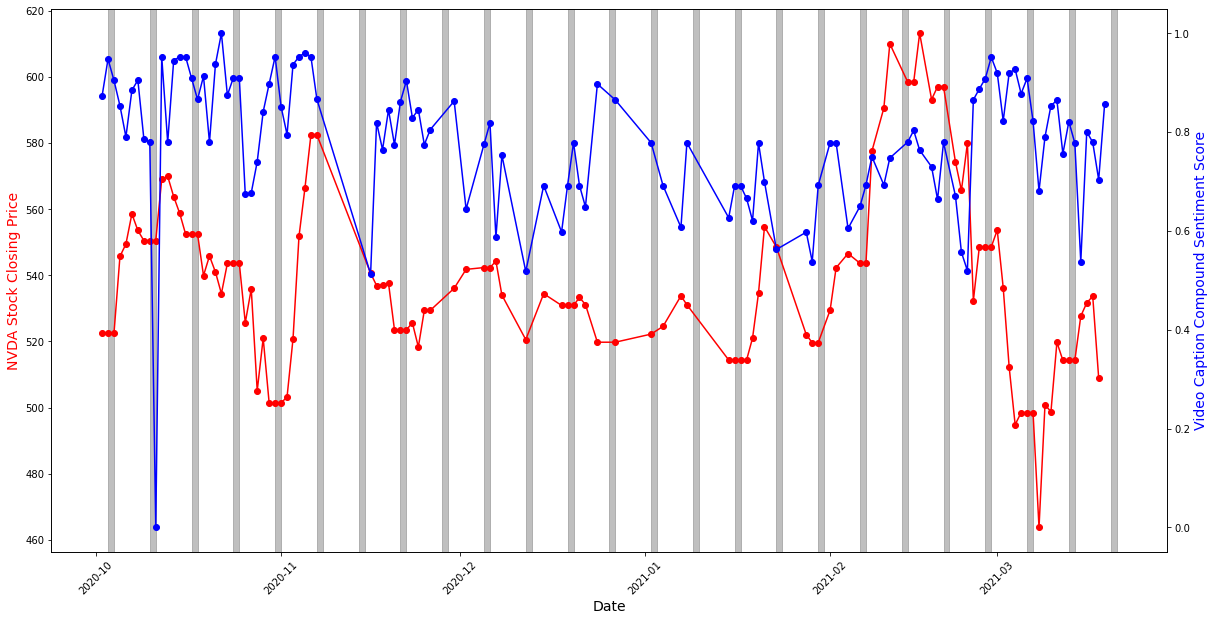

In [23]:
x = pd.DataFrame(X_agg_by_day_feautures_final.Date)
# print(full_joined_df["compound"])
y = pd.DataFrame(X_agg_by_day_feautures_final["captionSentimentScore_com"])

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Caption Compound Sentiment Score", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)

plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

X_agg_by_day_feautures_final["captionSentimentScore_com"] * X_agg_by_day_feautures_final["viewcounts_weighted"]### Plotting the fluctuations of price and caption compound * video title compound * by weighted view count

In [30]:
pd.DataFrame((X_agg_by_day_feautures_final["captionSentimentScore_com"] * X_agg_by_day_feautures_final["viewcounts_weighted"]))

,0
0,0.866968
1,0.943057
2,0.826849
3,0.722319
4,0.790280
...,...
113,0.112411
114,0.163299
115,0.157641
116,0.150213


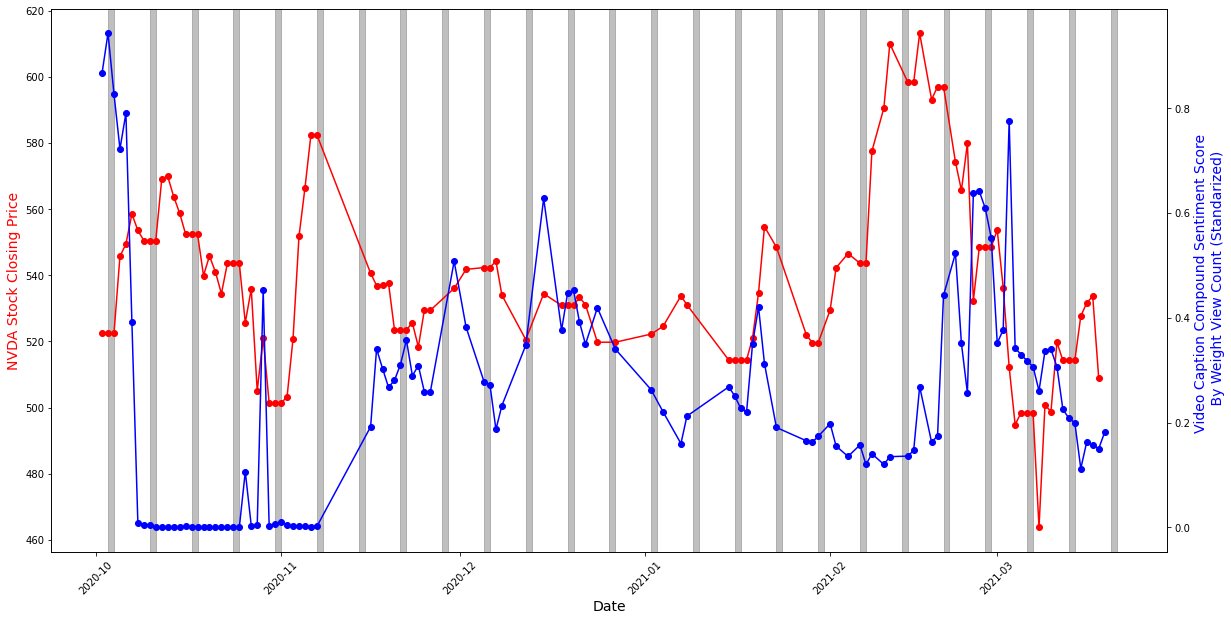

In [31]:
x = X_agg_by_day_feautures_final.Date
# print(full_joined_df["compound"])
y = X_agg_by_day_feautures_final["captionSentimentScore_com"] * X_agg_by_day_feautures_final["viewcounts_weighted"]

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, y, color="blue", marker="o")
ax2.set_ylabel("Video Caption Compound Sentiment Score \n By Weight View Count (Standarized)", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)
    
plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

### Plotting the fluctuations of price and caption compound video title by weighted view count

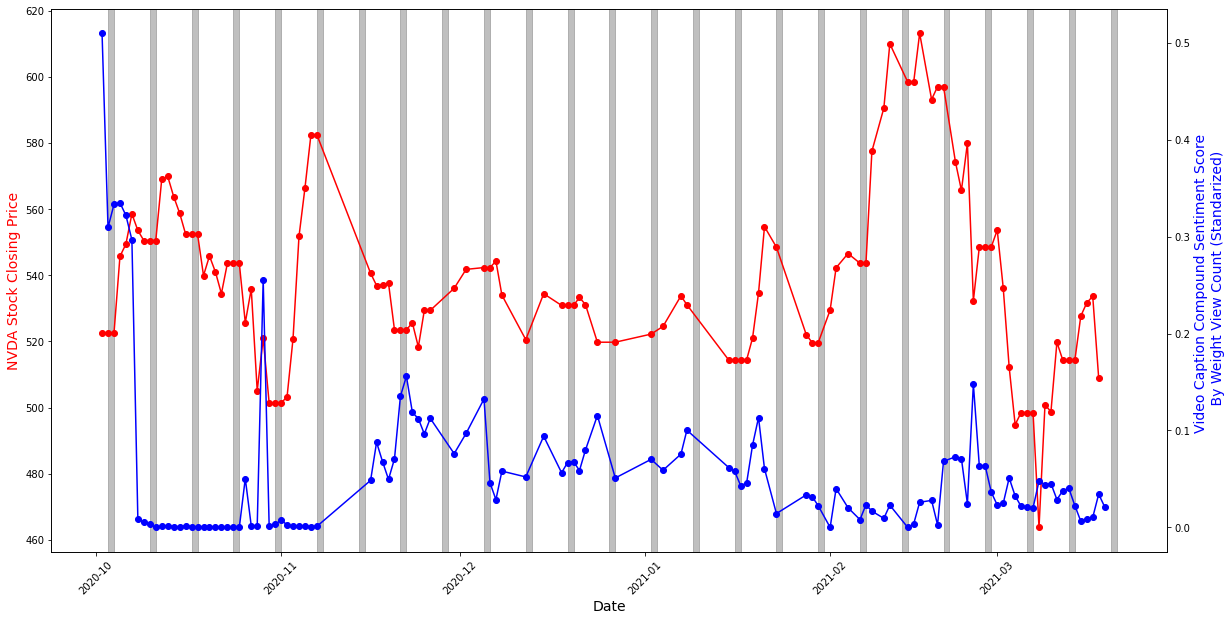

In [32]:
x = X_agg_by_day_feautures_final.Date
# print(full_joined_df["compound"])
y = X_agg_by_day_feautures_final["captionSentimentScore_com"] * X_agg_by_day_feautures_final["videoTitleSentimentScore_pos"] * X_agg_by_day_feautures_final["viewcounts_weighted"]

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Caption Compound Sentiment Score \n By Weight View Count (Standarized)", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)
    
plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

### Plotting the fluctuations of price and caption compound * video compound * weighted like dislike ratio by view count weight

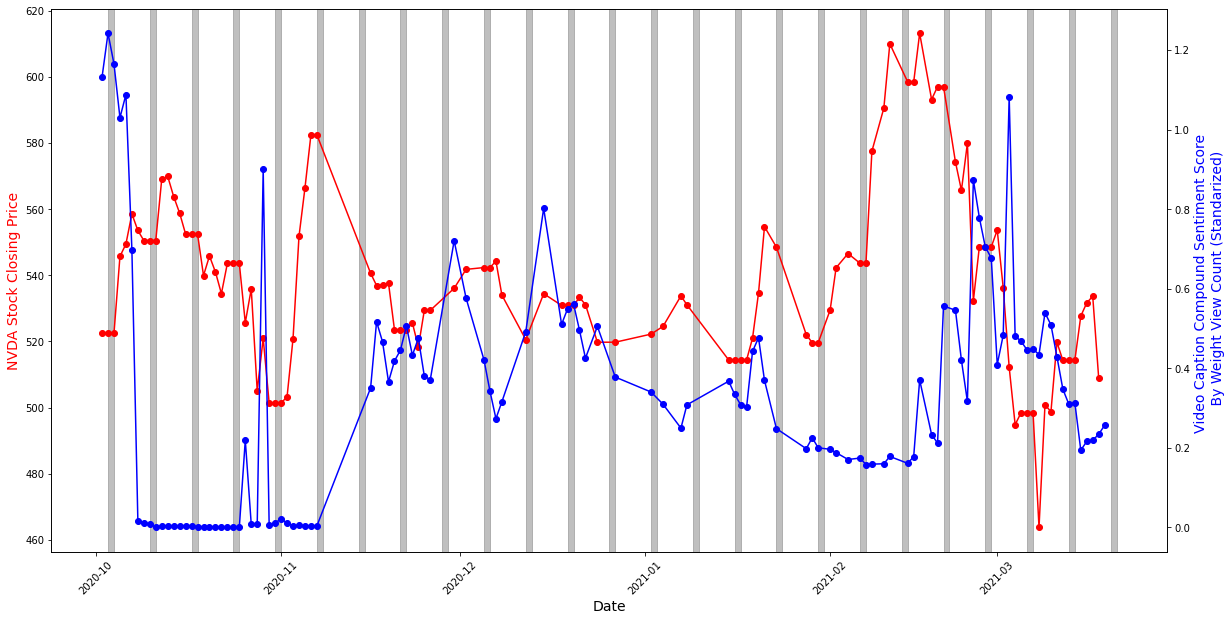

In [33]:
x = X_agg_by_day_feautures_final.Date
# print(full_joined_df["compound"])
y = (X_agg_by_day_feautures_final["captionSentimentScore_com"] + X_agg_by_day_feautures_final["videoTitleSentimentScore_com"]) * X_agg_by_day_feautures_final["like_dislike_ratio_by_viewcounts_weighted"]

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Caption Compound Sentiment Score \n By Weight View Count (Standarized)", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)
    
plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

### Subset by most viewed channels

In [34]:
#Find top video channels
mean_views = X_full_feautures_final["viewCount"].mean()
channels = X_full_feautures_final[X_full_feautures_final["viewCount"] > mean_views]["channelTitle"].unique()

In [35]:
channels

array(['NVIDIA GeForce', 'Linus Tech Tips', 'JayzTwoCents',
       'ShortCircuit', 'Gamers Nexus', 'Digital Foundry', 'TechLinked',
       'AMD', 'NVIDIA', 'TheRelaxingEnd', 'DataLover'], dtype=object)

In [39]:
subsetted_df =  X_full_feautures_final[X_full_feautures_final["channelTitle"].isin(channels)]

In [40]:
subsetted_df

,Unnamed: 0,Unnamed: 0.1,Index,videoID,datePub,searchedDate,VideoTitle,channelTitle,viewCount,likeCount,...,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,Date,index,percent_change,action,close,_merge
0,0,0,0,y4fb_R5Ogw0,2020-10-01 05:16:02+00:00,2020-10-02 01:45:21.553469+00:00,"2x NVIDIA RTX 3090 SLI Benchmarks: 500FPS, 700...",Gamers Nexus,367472,15701,...,260.000000,0.983710,0.983710,361485.989098,2020-10-02,2020-10-02,0.044362,buy,522.48999,both
2,2,2,2,E98hC9e__Xs,2020-09-01 16:42:07+00:00,2020-10-02 01:45:23.252012+00:00,NVIDIA GeForce RTX 30 Series | Official Launch...,NVIDIA GeForce,1484075,54741,...,36.612903,0.979687,0.979687,46900.942857,2020-10-02,2020-10-02,0.044362,buy,522.48999,both
3,3,3,3,nMns8t4OhI0,2020-09-30 23:00:06+00:00,2020-10-02 01:45:23.922084+00:00,NVIDIA Responds to RTX 3080 Crashes...,JayzTwoCents,561238,27766,...,442.500000,0.969111,0.969111,271950.966947,2020-10-02,2020-10-02,0.044362,buy,522.48999,both
4,4,4,4,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2020-10-02 01:45:24.592244+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3391565,141852,...,247.562500,0.972835,0.972835,206214.585797,2020-10-02,2020-10-02,0.044362,buy,522.48999,both
5,5,5,5,ucutmH2KvSQ,2020-09-02 02:30:02+00:00,2020-10-02 01:45:25.713383+00:00,NVIDIA just made EVERYTHING ELSE obsolete.,Linus Tech Tips,4996369,234736,...,137.866667,0.982685,0.982685,163661.943577,2020-10-02,2020-10-02,0.044362,buy,522.48999,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20780,20780,20780,12,3XaOeLPztN4,2020-10-27 12:59:59+00:00,2021-03-19 18:03:16.009357+00:00,I'm DONE covering for NVIDIA - RTX 3070 Review,Linus Tech Tips,3502810,134241,...,22.222222,0.976717,0.976717,23758.715720,2021-03-19,NaN,NaN,NaN,NaN,left_only
20782,20782,20782,14,YjcxrfEVhc8,2020-09-24 13:00:00+00:00,2021-03-19 18:03:17.157311+00:00,Making Nvidia’s CEO mad - RTX 3090 Review,Linus Tech Tips,3295273,144821,...,21.666667,0.974202,0.974202,18137.074330,2021-03-19,NaN,NaN,NaN,NaN,left_only
20788,20788,20788,20,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2021-03-19 18:03:20.670031+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3741789,148430,...,22.789189,0.972381,0.972381,19667.258436,2021-03-19,NaN,NaN,NaN,NaN,left_only
20790,20790,20790,22,H1DApIvOCMw,2021-02-26 17:35:37+00:00,2021-03-19 18:03:21.788746+00:00,My SALTY Review of the NVIDIA RTX 3060...,JayzTwoCents,1013948,51773,...,31.909091,0.986622,0.986622,45471.982159,2021-03-19,NaN,NaN,NaN,NaN,left_only


In [41]:
X_features = subsetted_df.filter(
    [
        "videoTitleSentimentScore_pos",
        "videoTitleSentimentScore_neg",
        "videoTitleSentimentScore_com",
        "captionSentimentScore_pos",
        "captionSentimentScore_neg",
        "captionSentimentScore_com",
        "num_days_since_pub",
        "viewcounts_weighted",
        "like_count_weighted",
        "like_dislike_ratio",
        "weighted_like_dislike_ratio",
        "like_dislike_ratio_by_viewcounts_weighted",
        "Date",
    ],
    axis=1,
)

X_feautures_pre_merge = X_features.groupby(["Date"]).mean().reset_index()

X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_agg_by_day_feautures_final = X_feautures_pre_merge.merge(
    responce_df, left_on="Date", right_on="index", how="left", indicator=True
)

columns = ['videoTitleSentimentScore_pos', 'videoTitleSentimentScore_neg',
       'videoTitleSentimentScore_com', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'num_days_since_pub', 'viewcounts_weighted', 'like_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted']

min_max_scaler = preprocessing.MinMaxScaler()
X_agg_by_day_feautures_final[columns] = min_max_scaler.fit_transform(X_agg_by_day_feautures_final[columns])
X_agg_by_day_feautures_final

,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,videoTitleSentimentScore_com,captionSentimentScore_pos,captionSentimentScore_neg,captionSentimentScore_com,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,index,percent_change,action,close,_merge
0,2020-10-02,0.669522,0.420063,0.567299,0.483911,0.672400,0.653295,0.016692,0.164032,0.130975,0.367209,0.367209,0.162419,2020-10-02,0.044362,buy,522.489990,both
1,2020-10-03,0.541223,0.313869,0.612680,0.380506,0.546802,0.521735,0.024333,0.168963,0.148935,0.410276,0.410276,0.167591,2020-10-03,0.041791,buy,522.489990,both
2,2020-10-04,0.481137,0.206192,0.704325,0.411622,0.600574,0.550896,0.036549,0.143873,0.118099,0.525069,0.525069,0.142704,2020-10-04,0.022541,hold,522.489990,both
3,2020-10-05,0.524104,0.213110,0.718213,0.384901,0.452655,0.515665,0.015155,0.136672,0.127859,0.383257,0.383257,0.135663,2020-10-05,0.013192,hold,545.700012,both
4,2020-10-06,0.533556,0.144493,0.782801,0.398510,0.506607,0.488321,0.011906,0.169173,0.166711,0.571507,0.571507,0.168759,2020-10-06,-0.022469,hold,549.460022,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2021-03-15,0.859216,0.101405,0.945984,0.517146,0.599859,0.502505,0.856319,0.023376,0.041599,0.249455,0.249455,0.023503,2021-03-15,-0.021599,hold,527.650024,both
85,2021-03-16,1.000000,0.141890,0.970878,0.802556,0.671594,0.725509,0.957167,0.015402,0.033897,0.151921,0.151921,0.015490,2021-03-16,-0.043737,sell,531.650024,both
86,2021-03-17,0.888981,0.109965,0.951247,0.733452,0.784446,0.744680,0.893121,0.018711,0.033547,0.245807,0.245807,0.018865,2021-03-17,-0.004367,hold,533.650024,both
87,2021-03-18,0.888981,0.109965,0.951247,0.733452,0.784446,0.744680,0.902779,0.017176,0.031516,0.244921,0.244921,0.017329,2021-03-18,0.012174,hold,508.899994,both


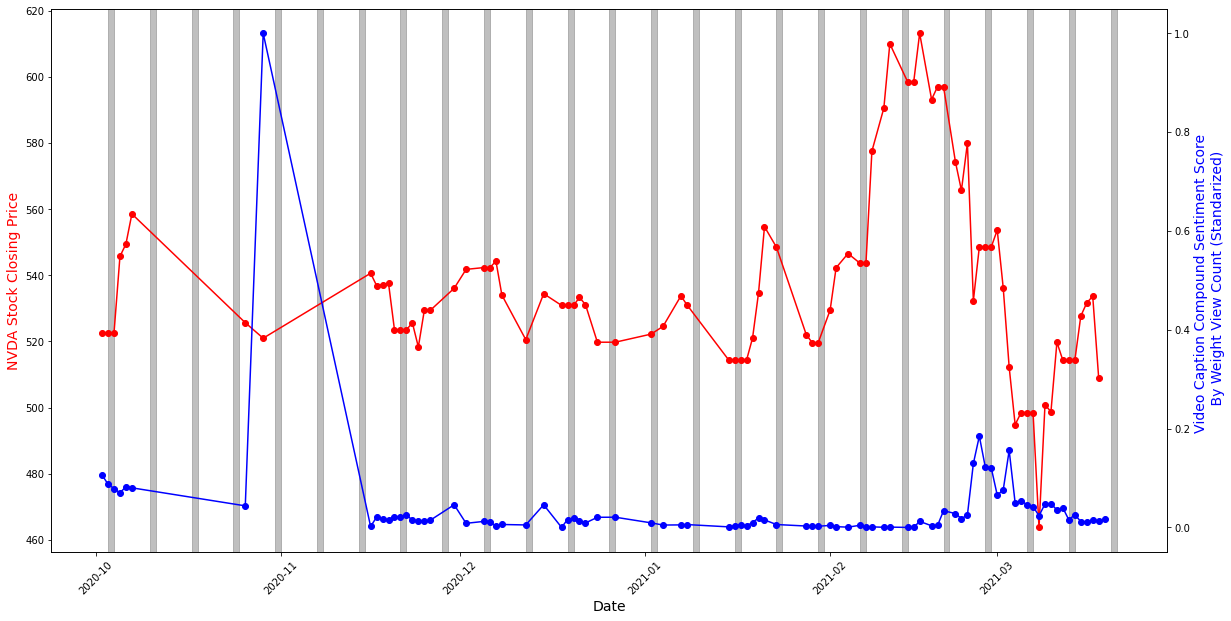

In [46]:
x = X_agg_by_day_feautures_final.Date
# print(full_joined_df["compound"])
y = X_agg_by_day_feautures_final["captionSentimentScore_com"] * X_agg_by_day_feautures_final["like_dislike_ratio_by_viewcounts_weighted"]

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Caption Compound Sentiment Score \n By Weight View Count (Standarized)", color="blue", fontsize=14)

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#print(indices)

sat = X_agg_by_day_feautures_final.Date[indices[0]]
sun = X_agg_by_day_feautures_final.Date[indices[0]] + timedelta(days=1)
for i in range(round(int((X_agg_by_day_feautures_final.Date[indices[-1]] - X_agg_by_day_feautures_final.Date[indices[0]]).days)/7)+2):
    ax.axvspan(sat, sun, alpha=0.5, color='gray')
    sat += timedelta(days=7)
    sun += timedelta(days=7)
    
plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

## APPENDIX

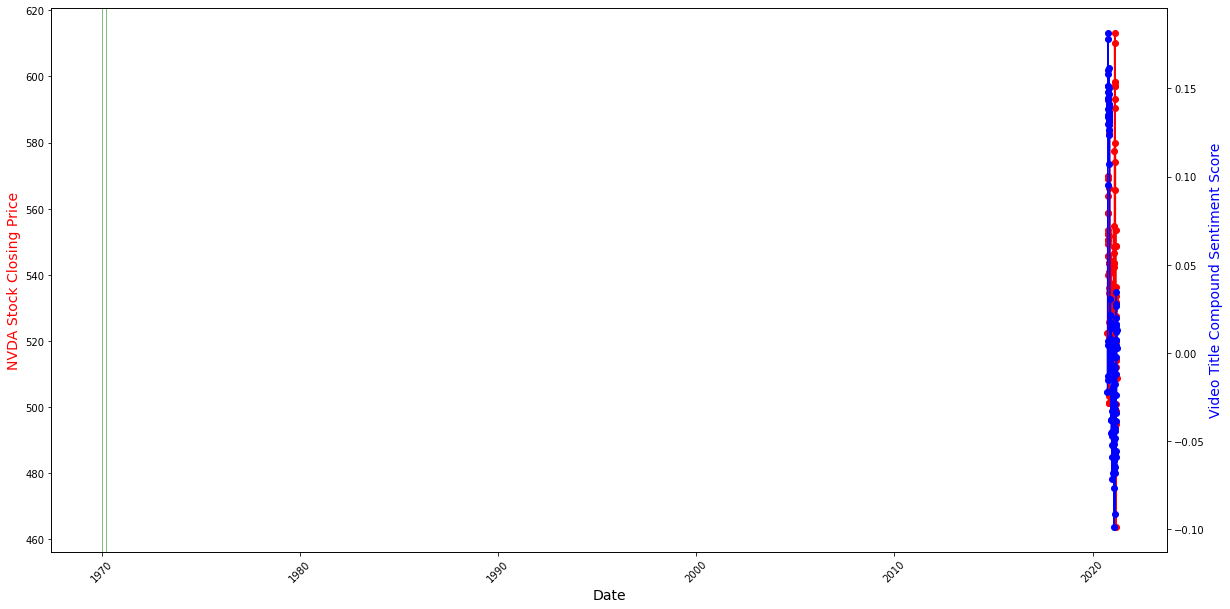

In [96]:
x = pd.DataFrame(X_agg_by_day_feautures_final.Date)
# print(full_joined_df["compound"])
y = pd.DataFrame(X_agg_by_day_feautures_final["videoTitleSentimentScore_com"])

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(20, 10))
# make a plot



def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

def find_occupied_hours(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() < 5:
            if datetime_array[i].hour >= 7 and datetime_array[i].hour <= 19:
                indices.append(i)
    return indices

def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(X_agg_by_day_feautures_final.Date.index[indices[i]], X_agg_by_day_feautures_final.Date.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.5)
        i += 1

#find to be highlighted areas, see functions
weekend_indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)

ax.plot(X_agg_by_day_feautures_final.Date, X_agg_by_day_feautures_final.close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date", fontsize=14)
plt.xticks(rotation=45)
# set y-axis label
ax.set_ylabel("NVDA Stock Closing Price", color="red", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(
    x, y, color="blue", marker="o",
)
ax2.set_ylabel("Video Title Compound Sentiment Score", color="blue", fontsize=14)
#highlight areas
highlight_datetimes(weekend_indices, ax)
plt.show()
# save the plot as a file
fig.savefig(
    "../20_graphics/NVDA_Sentiment_Stock_ComparisonPlot.jpeg",
    format="jpeg",
    dpi=200,
    bbox_inches="tight",
)

In [92]:
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

def find_occupied_hours(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() < 5:
            if datetime_array[i].hour >= 7 and datetime_array[i].hour <= 19:
                indices.append(i)
    return indices

def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.5)
        i += 1

#find to be highlighted areas, see functions
weekend_indices = find_weekend_indices(X_agg_by_day_feautures_final.Date)
#highlight areas

In [88]:
weekend_indices

[1,
 2,
 8,
 9,
 15,
 16,
 22,
 23,
 29,
 30,
 36,
 42,
 43,
 50,
 51,
 54,
 57,
 58,
 62,
 63,
 68,
 69,
 74,
 77,
 81,
 82,
 86,
 91,
 97,
 98,
 104,
 105,
 111,
 112]